# Analyzing MLP in Transformer-based Decision Making

This notebook explores the Multi-Layer Perception mechanisms in transformer models trained on decision sequences. We'll visualize and analyze what is represented in the Multi-Layer Perceptrons that lead to decision-making outputs (R, r, L, l).


In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model
from transformer.transformer import MLP, GPT, GPTConfig
from utils.parse_data import parse_simulated_data, get_data_filenames, add_sequence_columns
from interpretability.interp_helpers import tokenize
from interpretability import interp_helpers as interp
from interpretability import activations as act
from interpretability.activations import ActivationAnalyzer
%load_ext autoreload
%autoreload 2


In [2]:
sns.set_theme(style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 10,
        'axes.titlesize': 10,
        'savefig.transparent': True,
        'legend.title_fontsize': 10,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 10,
        'figure.subplot.wspace': 0.1,
        })

In [3]:
run = 36

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

# Load the model
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

# Print model configuration details
print(f"Number of layers: {config.n_layer}")
print(f"Number of attention heads: {config.n_head}")
print(f"Embedding dimension: {config.n_embd}")
print(f"Vocabulary size: {config.vocab_size}")
print(f"Block size (context length): {config.block_size}")

# Create a dummy MLP for analysis
dummy_mlp = MLP(config)

# Analyze MLP dimensions
mlp_input_dim = dummy_mlp.c_fc.in_features
mlp_hidden_dim = dummy_mlp.c_fc.out_features
mlp_output_dim = dummy_mlp.c_proj.out_features

print(f"\nMLP Dimensions Analysis:")
print(f"MLP Input Dimension: {mlp_input_dim}")
print(f"MLP Hidden Dimension: {mlp_hidden_dim}")
print(f"MLP Output Dimension: {mlp_output_dim}")

Using cpu device
Total number of parameters: 292
Number of layers: 1
Number of attention heads: 1
Embedding dimension: 4
Vocabulary size: 4
Block size (context length): 6

MLP Dimensions Analysis:
MLP Input Dimension: 4
MLP Hidden Dimension: 16
MLP Output Dimension: 4


In [4]:
# Analyze MLP parameters
mlp_params = sum(p.numel() for p in dummy_mlp.parameters() if p.requires_grad)
print(f"\nMLP Parameters: {mlp_params}")

# Detailed breakdown of MLP parameters
fc_params = dummy_mlp.c_fc.weight.numel() + (dummy_mlp.c_fc.bias.numel() if dummy_mlp.c_fc.bias is not None else 0)
proj_params = dummy_mlp.c_proj.weight.numel() + (dummy_mlp.c_proj.bias.numel() if dummy_mlp.c_proj.bias is not None else 0)

print(f"First linear layer (c_fc) parameters: {fc_params}")
print(f"  - Weight shape: {dummy_mlp.c_fc.weight.shape}")
print(f"  - Bias shape: {dummy_mlp.c_fc.bias.shape if dummy_mlp.c_fc.bias is not None else 'None'}")
print(f"Projection layer (c_proj) parameters: {proj_params}")
print(f"  - Weight shape: {dummy_mlp.c_proj.weight.shape}")
print(f"  - Bias shape: {dummy_mlp.c_proj.bias.shape if dummy_mlp.c_proj.bias is not None else 'None'}")

# Calculate percentage of parameters in MLP vs. total model
mlp_percentage = (mlp_params * config.n_layer / total_params) * 100

print(f"Each transformer block contains one MLP")
print(f"Total MLPs in model: {config.n_layer}")
print(f"Total parameters in all MLPs: {mlp_params * config.n_layer}")
print(f"MLPs account for {mlp_percentage:.2f}% of total model parameters")


MLP Parameters: 148
First linear layer (c_fc) parameters: 80
  - Weight shape: torch.Size([16, 4])
  - Bias shape: torch.Size([16])
Projection layer (c_proj) parameters: 68
  - Weight shape: torch.Size([4, 16])
  - Bias shape: torch.Size([4])
Each transformer block contains one MLP
Total MLPs in model: 1
Total parameters in all MLPs: 148
MLPs account for 50.68% of total model parameters


# 1. Extract MLP activations for different sequences


In [6]:
T = model_info['dataloader']['Sequence length (T)']
print(f"Sequence length: {T}")

# Get common sequences from data for analysis
num_sequences = 300
events, sequences, counts = interp.get_common_sequences(T, run=run, k=num_sequences)
print(f"Analyzing {num_sequences} sequences:\n{sequences[:20]}")

tokenized_sequences = interp.tokenize(sequences)
logits, loss = model(tokenized_sequences)
probs = F.softmax(logits[:, -1, :], dim=1)
max_probs, predicted_token = probs.max(dim=1)#.detach().cpu().numpy()

Sequence length: 6


Analyzing 300 sequences:
['LLLLLL', 'RRRRRR', 'LLLLLl', 'RRRRRr', 'LLLLlL', 'RRRRrR', 'LLLlLL', 'LLlLLL', 'RRRrRR', 'LlLLLL', 'RRrRRR', 'lLLLLL', 'RrRRRR', 'rRRRRR', 'rLLLLL', 'lRRRRR', 'rrLLLL', 'llRRRR', 'RRRRrr', 'LLLLll']


In [8]:
analyzer = ActivationAnalyzer(model, config, model_component='mlp')

In [10]:
# Collect MLP activations for each sequence as (mlp_input_dim=nneurons x T)
activations = analyzer.get_activations(sequences)

# 2. Analyze which neurons are most active for different decisions

# 3. Analyze neuron specialization - do certain neurons always activate for R vs L?

In [11]:
# Extract last token position activations for each layer
last_pos_by_layer = analyzer.get_activation_by_position(activations, token_pos=-1)

# Find the most active neurons for each sequence
top_neurons = {}
for seq, act in last_pos_by_layer['input'].items():
    # Get top 5 neurons with highest activation
    top_idx = np.argsort(act)[-5:]
    top_values = act[top_idx]
    top_neurons[seq] = list(zip(top_idx, top_values))

# print("Top active neurons for each sequence:")
# for seq, neurons in top_neurons.items():
#     print(f"{seq}: {neurons}")

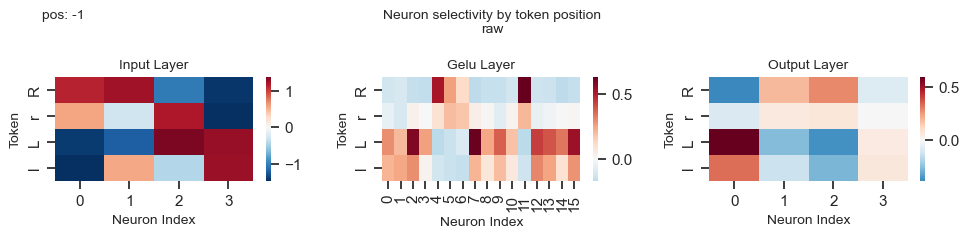

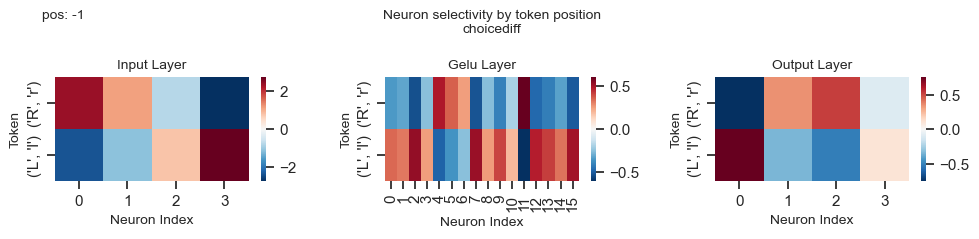

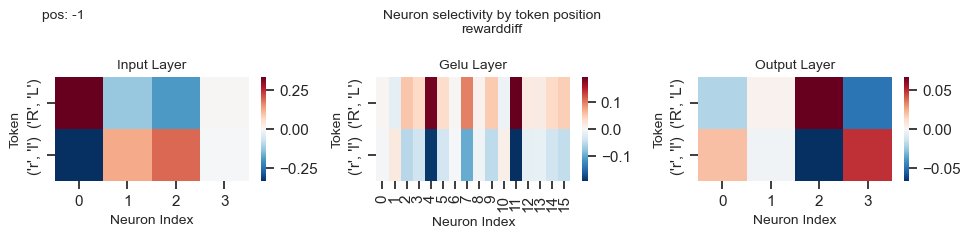

In [12]:
raw_responses = analyzer.analyze_layer_specialization(activations, token_pos=-1, method='raw')
choice_responses = analyzer.analyze_layer_specialization(activations, token_pos=-1, method='choicediff')
reward_responses = analyzer.analyze_layer_specialization(activations, token_pos=-1, method='rewarddiff')

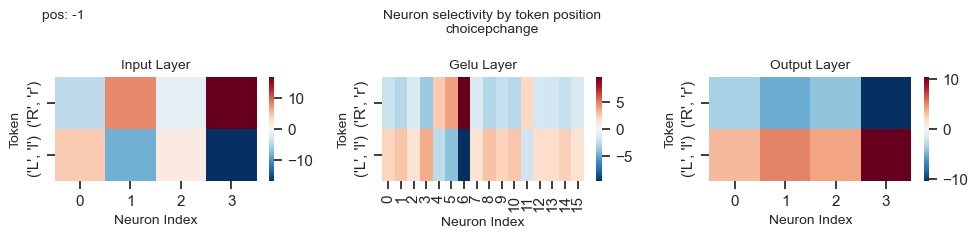

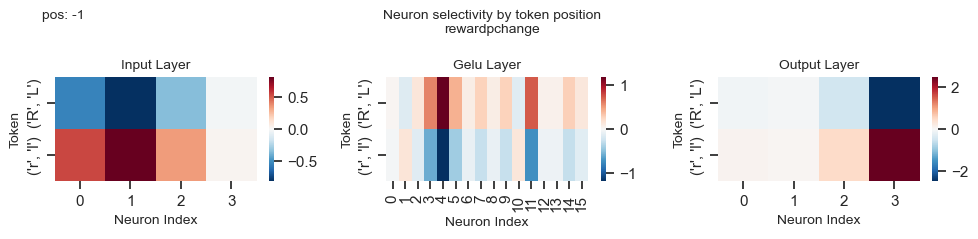

In [13]:
choice_pchange = analyzer.analyze_layer_specialization(activations, token_pos=-1, method='choicepchange')
reward_pchange = analyzer.analyze_layer_specialization(activations, token_pos=-1, method='rewardpchange')


# 5. Cluster Sequences by Activation Patterns

In [16]:
from sklearn.manifold import TSNE
# import umap

def prepare_pca_embeddings(activations, sequences, layer, token_pos=-1, n_components=4, sequence_method='token', method='pca'):

    if sequence_method == 'token':
        pos_activations = analyzer.get_activation_by_position(activations, token_pos=token_pos)
        X = np.array([pos_activations[layer][seq] for seq in sequences])
    elif sequence_method == 'concat':
        X = np.concatenate([activations[seq][layer].reshape(1, -1) for seq in sequences], axis=0)

    if method == 'tsne':
        model = TSNE(n_components=2)
        X_embedding = model.fit_transform(X)
    elif method == 'pca':
        # Use PCA to reduce dimensions
        model = PCA(n_components=n_components)
        X_embedding = model.fit_transform(X)

    return model, X_embedding


def plot_pca_by_layer(activations, sequences, counts=None, layers=None, token_pos=-1, n_components=4, sequence_method='token', method='pca', variance_explained=True):

    if layers is None:
        layers = ['input', 'gelu', 'output']
    elif not isinstance(layers, list):
        layers = [layers]
    
    if variance_explained:
        fig, (axs1, axs2) = plt.subplots(ncols=len(layers), nrows=2, figsize=(len(layers)*3, 4),
                        layout='constrained', gridspec_kw={'height_ratios': [2, 1]})
    else:
        fig, axs1 = plt.subplots(ncols=len(layers), nrows=1, figsize=(len(layers)*3, 2.5),
                        layout='constrained')
        axs2 = None

    if len(layers) == 1:
        axs1 = [axs1]
        axs2 = [axs2]

    if counts is not None:
        norm_counts = np.log1p(counts) / np.log1p(np.max(counts))

    for j, (ax, layer) in enumerate(zip(axs1, layers)):
            
        model, X_embedding = prepare_pca_embeddings(activations, sequences, layer, token_pos=token_pos,
                                                n_components=n_components, sequence_method=sequence_method, method=method)

        if counts is not None:
            for i, (seq, c) in enumerate(zip(sequences, norm_counts)):
                ax.scatter(X_embedding[i, 0], X_embedding[i, 1], 
                        color='red' if seq[token_pos] in ('R', 'r') else 'blue',
                        marker = 'o' if seq[token_pos] in ('R', 'L') else 'x',
                        alpha=c,
                        s=10 * c)
                if len(sequences) < 20:
                    ax.annotate(seq[token_pos], (X_embedding[i, 0], X_embedding[i, 1]), fontsize=12)
        else:            
            for i, seq in enumerate(sequences):
                ax.scatter(X_embedding[i, 0], X_embedding[i, 1], 
                        color='red' if seq[token_pos] in ('R', 'r') else 'blue',
                        marker = 'o' if seq[token_pos] in ('R', 'L') else 'x',
                        s=10)

        ax.set(title=layer.capitalize(),
                xlabel='Dim 1',
                ylabel='Dim 2')

        if method == 'pca' and variance_explained:
            # Variance explained (inverse scree plots)
            axs2[j].plot(range(1, n_components + 1),
                        np.cumsum(model.explained_variance_ratio_),
                        marker='o', color='red')
            axs2[j].set(xlabel='Dimension', xticks=range(1, n_components + 1),
                        ylabel='Explained Variance Ratio', ylim=(0, 1.05) )

    fig.suptitle(f'Dimensions of MLP Activations for {token_pos}th position')
    plt.subplots_adjust(top=0.9)
    sns.despine()

    return fig, (axs1, axs2)

/var/folders/bb/552md4fn27l5zpqklwc2jpf40000gn/T/ipykernel_4720/2123409472.py:83: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.9)


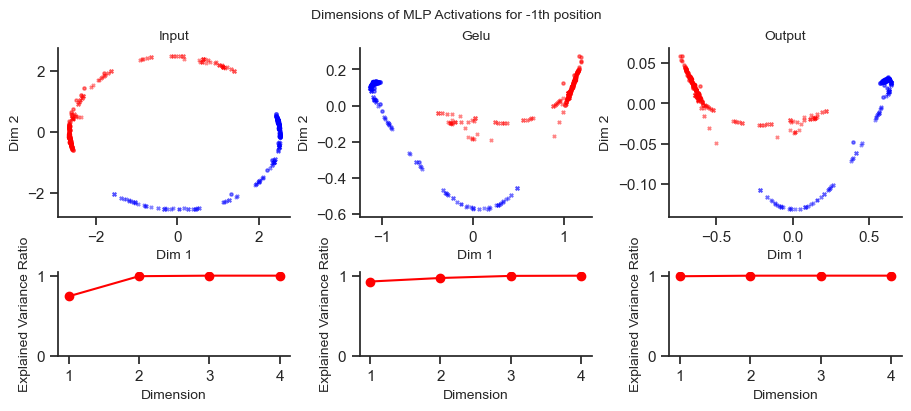

In [17]:
fig, axs = plot_pca_by_layer(activations, sequences, counts)

/var/folders/bb/552md4fn27l5zpqklwc2jpf40000gn/T/ipykernel_4720/2123409472.py:83: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.9)


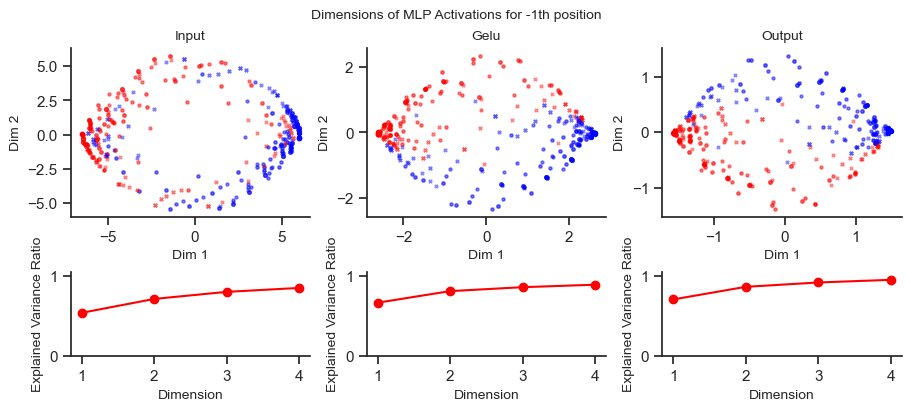

In [18]:
fig, axs = plot_pca_by_layer(activations, sequences, counts, token_pos=-1, sequence_method='concat')

/var/folders/bb/552md4fn27l5zpqklwc2jpf40000gn/T/ipykernel_4720/2123409472.py:83: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.9)


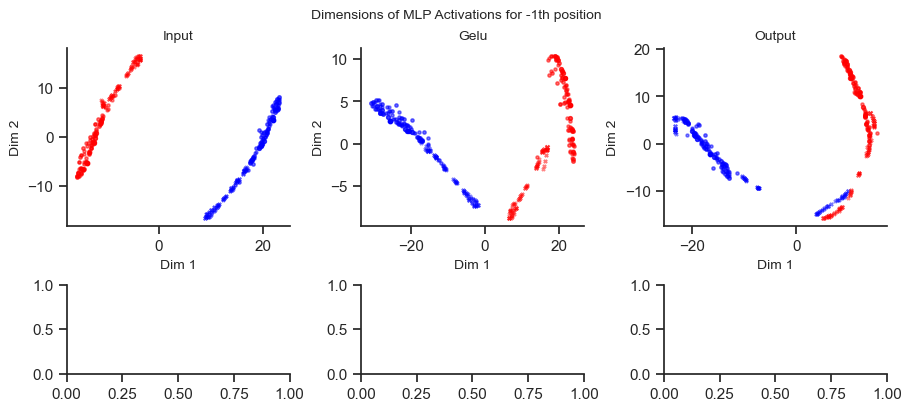

In [19]:
fig, axs = plot_pca_by_layer(activations, sequences, counts, token_pos=-1, method='tsne')

/var/folders/bb/552md4fn27l5zpqklwc2jpf40000gn/T/ipykernel_4720/2123409472.py:83: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.9)


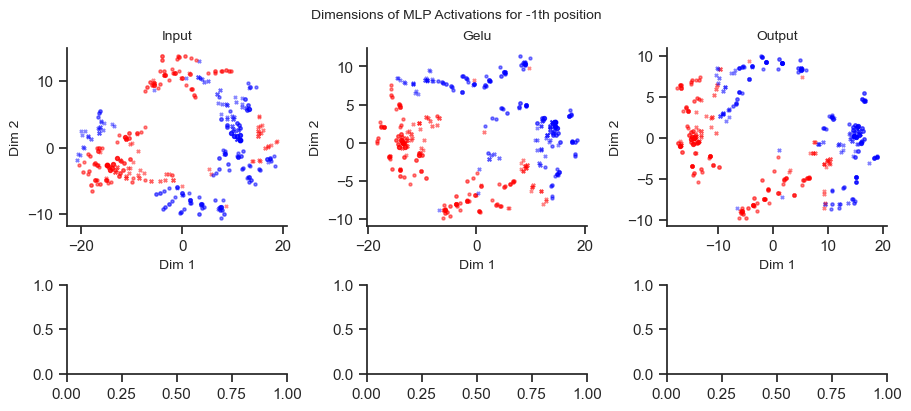

In [20]:
fig, axs = plot_pca_by_layer(activations, sequences, counts, token_pos=-1, sequence_method='concat', method='tsne')

In [21]:
events.query('high_port == 1')['k0'].value_counts()

k0
R    380463
l     65764
r     42447
L      7429
Name: count, dtype: int64

In [22]:
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}

In [48]:
from activations import DimensionalityReductionConfig

dr_config = DimensionalityReductionConfig(
    token_pos=-1,
    sequence_method='token',
    n_components=2
)
block_sequences  = interp.get_block_transition_sequences(events, T, high_port=1)

/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/activations.py:660: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.9)
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/activations.py:660: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.9)
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/activations.py:660: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.9)
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/activations.py:660: UserWarning: This figure was using a layout engine

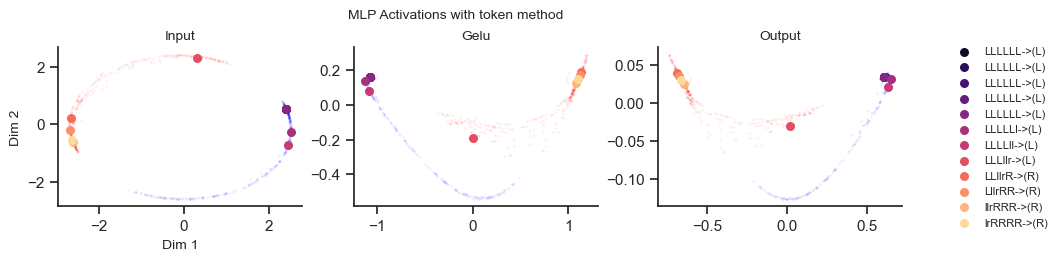

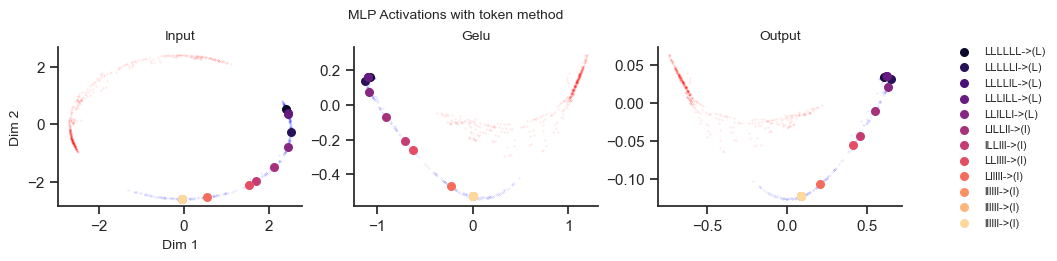

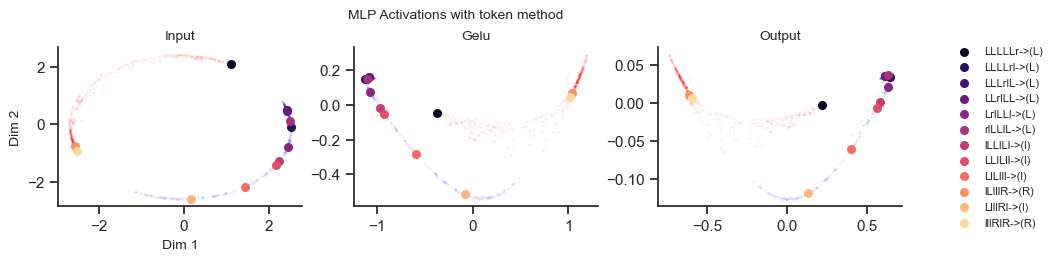

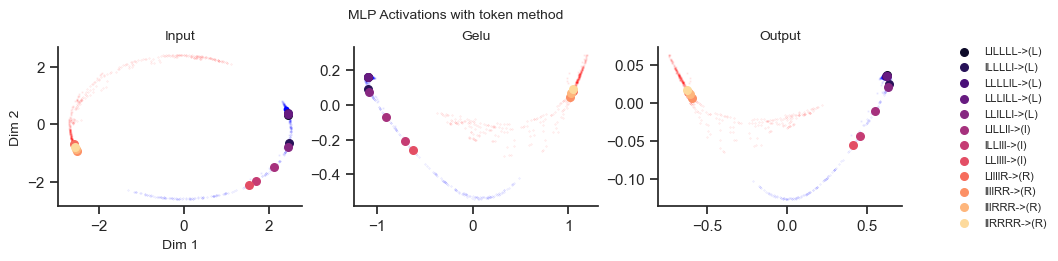

In [47]:
for transition in range(10, 14):
    fig,axs = analyzer.plot_pca_across_trials(activations, sequences, block_sequences[transition], ['input', 'gelu', 'output'], dr_config)

# 6. Correlation Matrix between Neurons

In [26]:
import interp_helpers as interp

Text(0.5, 0.98, 'Within-Layer Neuron Correlations')

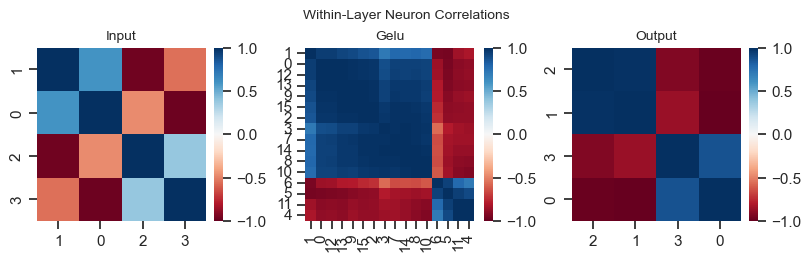

In [27]:
fig, axs = plt.subplots(ncols=3,figsize=(8, 2.5), layout='constrained')
for ax, layer in zip(axs, ['input', 'gelu', 'output']):

    # Calculate correlation between neurons (input layer)
    neuron_corr = pd.DataFrame(last_pos_by_layer[layer]).T.corr()

    ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(neuron_corr.to_numpy(), np.arange(len(neuron_corr)), replot=False)
    plt.close()
    interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=ax)
    ax.set_title(layer.capitalize())

fig.suptitle("Within-Layer Neuron Correlations")

# 7. Probing to find maximal activation across layers

In [29]:
events, sequences, counts = interp.get_common_sequences(T, events=events, k=1000)
activations = analyzer.get_activations(sequences)
last_pos_by_layer = analyzer.get_activation_by_position(activations, token_pos=-1)

In [21]:
layer_composition = {
    'input': mlp_input_dim,
    'gelu': mlp_hidden_dim,
    'output': mlp_output_dim
}

In [32]:
# Find maximal activations for each layer
max_activations = {}
for layer_name in analyzer.layers:
    max_activations[layer_name] = analyzer.find_maximal_activations(
        last_pos_by_layer, layer_name, sequences)
    
    # Print example results for a few neurons
    print(f"\n{layer_name.upper()} LAYER - Top activating sequences:")
    for neuron_idx in range(min(5, len(max_activations[layer_name]))):  # Show first 5 neurons
        print(f"Neuron {neuron_idx}: ", end="")
        for seq, act in max_activations[layer_name][neuron_idx][:5]:
            print(f"{seq} ({act:.3f})", end=" | ")
        print()


INPUT LAYER - Top activating sequences:
Neuron 0: rrrrrR (1.573) | RrrrrR (1.525) | rRrrrR (1.522) | lrrrrR (1.509) | rrRrrR (1.507) | 
Neuron 1: RRRRRl (1.747) | RlRRRl (1.737) | RRlRRl (1.735) | RRRlRl (1.734) | RRRRll (1.733) | 
Neuron 2: lLLLLr (2.198) | LlLLLr (2.196) | LLlLLr (2.195) | LLLlLr (2.195) | LLLLlr (2.194) | 
Neuron 3: LLLlll (1.839) | LLlLll (1.838) | LLllLl (1.837) | LlLLll (1.834) | LlLlLl (1.833) | 

GELU LAYER - Top activating sequences:
Neuron 0: LlLLLl (0.345) | LLlLLl (0.345) | rLLLll (0.345) | LLLlLl (0.345) | rLLlLl (0.344) | 
Neuron 1: LllLLl (0.335) | LlLlLl (0.335) | LlLLll (0.335) | LLllLl (0.334) | LLLlRl (0.334) | 
Neuron 2: LLLLrl (0.602) | LLLrrl (0.602) | LLrrLl (0.602) | LLLrLl (0.601) | LLrLLl (0.601) | 
Neuron 3: LrrrrL (0.275) | LLrrrL (0.275) | rrrrrL (0.274) | rLrrrL (0.274) | rrLrrL (0.274) | 
Neuron 4: rRRrrR (0.566) | rRrRrR (0.565) | RrRrrR (0.565) | RRrrrR (0.565) | rRrrRR (0.564) | 

OUTPUT LAYER - Top activating sequences:
Neuron 0: LLL

In [33]:
def get_average_sequence(token_counts_df, single_threshold=0.6, joint_threshold=0.4):
    """
    Extract tokens based on probability rules:
    1. If highest prob token > single_threshold, use that token
    2. If top two tokens together > joint_threshold, use "(token1/token2)"
    3. Otherwise use "-"
    
    Parameters:
    -----------
    token_counts_df : pandas.DataFrame
        DataFrame where rows are sequence positions, columns are tokens,
        and values are probabilities
    single_threshold : float
        Threshold for using a single token
    joint_threshold : float
        Threshold for using a pair of tokens
    
    Returns:
    --------
    list
        A list of tokens, token pairs, or dashes for each position
    """
    token_sequence = []
    
    for idx, row in token_counts_df.iterrows():
        # Sort the tokens by probability in descending order
        sorted_tokens = row.sort_values(ascending=False)
        
        top_token = sorted_tokens.index[0]
        top_prob = sorted_tokens.iloc[0]
        
        # If the top token is confident enough, use it
        if top_prob > single_threshold:
            token_sequence.append(top_token)
        else:
            # Check if the top two tokens together indicate a specific uncertainty
            second_token = sorted_tokens.index[1]
            second_prob = sorted_tokens.iloc[1]
            
            if top_prob > joint_threshold and second_prob > joint_threshold:
                # The model is specifically uncertain between these two tokens
                token_sequence.append(f"({top_token}/{second_token})")
            else:
                # The model is uncertain across many tokens
                token_sequence.append('-')
    
    return ''.join(token_sequence)

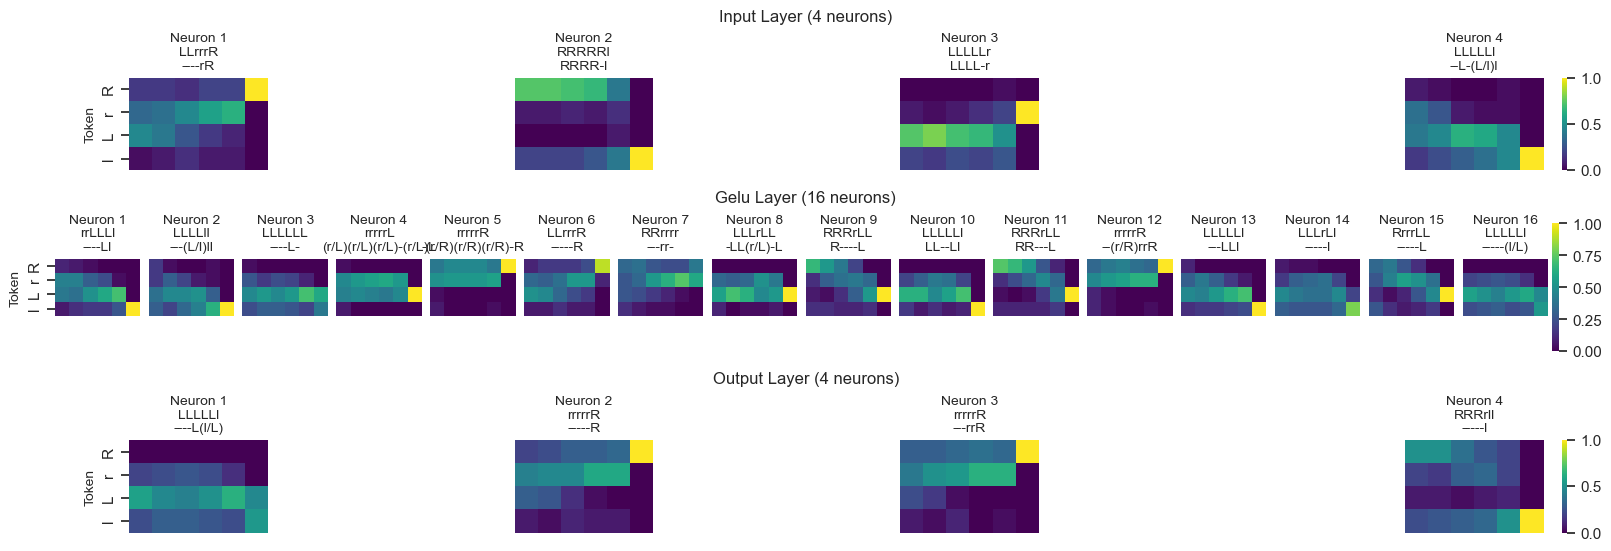

In [35]:
def create_mlp_visualization(
    neurons_per_layer: dict[str, int],
    fig_title: str = None
) -> tuple[plt.Figure, dict[int, list[plt.Axes]]]:
    """
    Create a matplotlib figure with subfigures for neural network visualization.
    
    Parameters:
    -----------
    neurons_per_layer : Dict[str, int]
        Number of neurons (axes) to create for each layer
    fig_title : str, optional
        Overall figure title
        
    Returns:
    --------
    fig : plt.Figure
        The main figure object
    axes_dict : Dict[str, List[plt.Axes]]
        Dictionary mapping layer name to list of axes for that layer
    """
    # Determine number of layers if not specified
    n_layers = len(neurons_per_layer)
    
    figsize = (max(neurons_per_layer.values()) * 1, n_layers * 1.8)
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    
    if fig_title:
        fig.suptitle(fig_title, fontsize=12)
    
    subfigs = fig.subfigures(n_layers, 1)  # subfigure for each layer
    
    if n_layers == 1:
        subfigs = [subfigs]
    
    axes_dict = {}
    
    # Create axes for each neuron in each layer
    for subfig, (layer_name, n_neurons) in zip(subfigs, neurons_per_layer.items()):
        
        subfig.suptitle(f"{layer_name.capitalize()} Layer ({n_neurons} neurons)", fontsize=12)
        
        axes = subfig.subplots(nrows=1, ncols=n_neurons)
        if n_neurons == 1:
            axes = [axes]
        axes_dict[layer_name] = axes
    
    return fig, axes_dict


def count_tokens(seqs):
    
    # Count token frequencies at each position across these sequences
    token_counts = []
    for pos in range(len(seqs[0])):  # Assuming all sequences have same length
        pos_counts = {'R': 0, 'r': 0, 'L': 0, 'l': 0}
        for seq in seqs:
            pos_counts[seq[pos]] += 1
        token_counts.append(pos_counts)

    return pd.DataFrame(token_counts)


def describe_pattern_verbose(token_counts, layer, seqs):
    '''Analyze if this neuron might be detecting specific patterns'''
    print(f"\nPatterns detected by {layer} layer, Neuron {neuron_idx}:")
    
    # Check for position-specific token preferences
    for row, freq in token_counts.iterrows():
        if any(freq > 0.7):
            max_token = freq[freq > 0.7].index[0]
            print(f"Position {row}: Strong preference for '{max_token}'")
    
    # Check for contextual patterns
    # Check if neuron responds to recent history
    last_tokens = [seq[-1] for seq in seqs]
    if all(token in ['R', 'r'] for token in last_tokens) or all(token in ['L', 'l'] for token in last_tokens):
        print("→ This neuron strongly responds to the type of the most recent decision (R/r vs L/l)")
    
    # Check for alternating patterns
    alternating_count = sum(1 for seq in seqs if 'RL' in seq or 'LR' in seq)
    if alternating_count >= len(seqs) * 0.7:
        print("→ This neuron may be detecting alternating patterns between R and L")
    
    # Check for repeated patterns
    repeat_count = sum(1 for seq in seqs if 'RR' in seq or 'LL' in seq)
    if repeat_count >= len(seqs) * 0.7:
        print("→ This neuron may be detecting repeated tokens of the same type")


def analyze_neuron_patterns(layer_name, neuron_idx, ax=None, **kwargs):
    """Analyze patterns in sequences that maximally activate a specific neuron"""
    # Get sequences that maximally activate this neuron
    max_seqs = [seq for seq, _ in max_activations[layer_name][neuron_idx]]

    token_counts = count_tokens(max_seqs)
    
    # Normalize counts
    token_counts = token_counts.div(token_counts.sum(axis=1), axis=0)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set(title=f'{layer_name.capitalize()} Layer, Neuron {neuron_idx} - Token Patterns')
        describe_pattern_verbose(token_counts, layer_name, max_seqs)
    sns.heatmap(token_counts.T, cmap='viridis', annot=False, fmt='.2f', ax=ax, vmin=0, vmax=1, **kwargs)
    
    ax.set(xlabel='Position in Sequence', ylabel='Token')

    return ax, token_counts


fig, axes_dict = create_mlp_visualization(
    neurons_per_layer=analyzer.layer_composition,
)

for layer_name, axes in axes_dict.items():

    for neuron_idx, ax in enumerate(axes):
        ax, token_counts = analyze_neuron_patterns(layer_name, neuron_idx, ax=ax, cbar=neuron_idx == (len(axes)-1))
        avg_sequence = get_average_sequence(token_counts, single_threshold=0, joint_threshold=0)
        avg_sequence_thresholded = get_average_sequence(token_counts, single_threshold=0.6, joint_threshold=0.4)
        ax.set(title=f"Neuron {neuron_idx+1}\n{avg_sequence}\n{avg_sequence_thresholded}", xticks=[])
        ax.set_aspect(1)
        if neuron_idx > 0:
            ax.set(ylabel='', yticks=[])
        # if layer_name != 'output':
        ax.set(xlabel='')


# 8. Probing by Generating Synthetic Inputs

In [26]:
# def generate_maximal_input(layer_name, neuron_idx, iterations=100, lr=0.1):
#     """Generate a synthetic input that maximally activates a specific neuron"""
#     # Create a soft representation of a sequence (probabilities over vocabulary)
#     sequence_length = 6  # Same as our training sequences
    
#     # Initialize with uniform probabilities - properly create a leaf tensor
#     token_probs = torch.ones((sequence_length, len(vocab)), device=device) / len(vocab)
#     token_probs = token_probs.clone().detach().requires_grad_(True)  # Make it a proper leaf tensor
    
#     # Create optimizer
#     optimizer = torch.optim.Adam([token_probs], lr=lr)
    
#     # Optimization loop
#     activation_history = []
    
#     for i in range(iterations):
#         optimizer.zero_grad()
        
#         # Generate a soft one-hot encoding of the sequence
#         soft_tokens = F.gumbel_softmax(token_probs, tau=1.0, hard=False, dim=-1)
        
#         # Create embeddings from soft tokens - fix the matrix multiplication
#         # Get embedding dimension
#         embed_dim = model.transformer.wte.weight.shape[1]
        
#         # Initialize an empty tensor for the embeddings
#         token_embeds = torch.zeros((sequence_length, embed_dim), device=device)
        
#         # For each position, compute the weighted sum of embeddings
#         for pos in range(sequence_length):
#             for token_idx in range(len(vocab)):
#                 token_embeds[pos] += soft_tokens[pos, token_idx] * model.transformer.wte.weight[token_idx]
        
#         # Add position embeddings
#         pos = torch.arange(0, sequence_length, dtype=torch.long, device=device)
#         pos_embeds = model.transformer.wpe(pos)
#         x = token_embeds + pos_embeds
        
#         # Add batch dimension
#         x = x.unsqueeze(0)
        
#         # Forward through the model layers until the target layer
#         if layer_name == 'input':
#             # Input to MLP is after attention and layer norm
#             for block in model.transformer.h:
#                 ln_1_out = block.ln_1(x)
#                 attn_out = block.attn(ln_1_out)
#                 x = x + attn_out
#                 target_activation = block.ln_2(x)[0, -1, neuron_idx]
#                 break
                
#         elif layer_name == 'hidden':
#             # Hidden layer is after first linear layer in MLP
#             for block in model.transformer.h:
#                 ln_1_out = block.ln_1(x)
#                 attn_out = block.attn(ln_1_out)
#                 x = x + attn_out
#                 ln_2_out = block.ln_2(x)
#                 target_activation = block.mlp.c_fc(ln_2_out)[0, -1, neuron_idx]
#                 break
                
#         elif layer_name == 'gelu':
#             # After GELU activation
#             for block in model.transformer.h:
#                 ln_1_out = block.ln_1(x)
#                 attn_out = block.attn(ln_1_out)
#                 x = x + attn_out
#                 ln_2_out = block.ln_2(x)
#                 fc_out = block.mlp.c_fc(ln_2_out)
#                 target_activation = block.mlp.gelu(fc_out)[0, -1, neuron_idx]
#                 break
                
#         elif layer_name == 'output':
#             # Output of MLP
#             for block in model.transformer.h:
#                 ln_1_out = block.ln_1(x)
#                 attn_out = block.attn(ln_1_out)
#                 x = x + attn_out
#                 ln_2_out = block.ln_2(x)
#                 mlp_out = block.mlp(ln_2_out)
#                 target_activation = mlp_out[0, -1, neuron_idx]
#                 break
        
#         # Maximize the target activation
#         loss = -target_activation
#         loss.backward()
#         optimizer.step()
        
#         # Record activation value
#         activation_history.append(target_activation.item())
        
#         # Ensure probabilities sum to 1
#         with torch.no_grad():
#             token_probs.data = F.softmax(token_probs.data, dim=-1)
    
#     # Convert soft tokens to most likely sequence
#     with torch.no_grad():
#         best_tokens = torch.argmax(token_probs, dim=-1).cpu().numpy()
#     best_sequence = ''.join([vocab[idx] for idx in best_tokens])
    
#     # Find the iteration with the highest activation
#     best_iteration = np.argmax(activation_history)
#     best_activation = activation_history[best_iteration]
    
#     # Visualize token probabilities for the optimized sequence
#     token_probs_np = token_probs.detach().cpu().numpy()
    
#     plt.figure(figsize=(12, 8))
    
#     # Plot final activation achieved
#     plt.subplot(2, 1, 1)
#     plt.plot(activation_history)
#     plt.axvline(x=best_iteration, color='r', linestyle='--', label=f'Best at iteration {best_iteration}')
#     plt.title(f'Neuron Activation Over Optimization ({layer_name} layer, neuron {neuron_idx})')
#     plt.xlabel('Iteration')
#     plt.ylabel('Activation')
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.legend()
    
#     # Plot token probabilities for each position
#     plt.subplot(2, 1, 2)
#     sns.heatmap(token_probs_np, annot=True, fmt='.2f', cmap='viridis',
#                 xticklabels=vocab, yticklabels=range(sequence_length))
#     plt.title(f'Optimized Token Probabilities (Best sequence: {best_sequence})')
#     plt.xlabel('Token')
#     plt.ylabel('Position')
    
#     plt.tight_layout()
#     plt.show()
    
#     return best_sequence, token_probs_np, activation_history, best_iteration, best_activation

# # Choose specific neurons to probe from different layers
# for layer_name in ['input', 'hidden', 'gelu', 'output']:
#     # Since max_activations may not be available, choose a fixed neuron index
#     # For hidden layer (dimension 32), try neuron 5
#     # For output layer (dimension 8), try neuron 2
#     if layer_name == 'hidden':
#         neuron_idx = 5  # Or any index < 32 (hidden dimension)
#     else:  # 'output'
#         neuron_idx = 2  # Or any index < 8 (output dimension)
    
#     print(f"\nGenerating maximal input for {layer_name} layer, neuron {neuron_idx}...")
#     best_seq, probs, history, best_iter, best_act = generate_maximal_input(layer_name, neuron_idx)
#     print(f"Best sequence: {best_seq}")
#     print(f"Best iteration: {best_iter}")
#     print(f"Best activation: {best_act:.4f}")

# 9. MLP Layer Interp

In [16]:
# sequences = vc[vc > 50].index.tolist()[:50]

# detailed_activations = {}
# for seq in sequences:
#     detailed_activations[seq] = get_mlp_detailed_activations(model, seq, vocab, stoi)
# last_pos_by_layer = {
#     layer_name: {
#         seq: detailed_activations[seq][layer_name][0][0, -1, :] 
#         for seq in sequences
#     }
#     for layer_name in ['input', 'hidden', 'gelu', 'output']
# }

In [36]:

def compare_layer_representations(activations_by_layer, layers=None):
    """Compare how representations evolve through the MLP layers"""
    
    if layers is None:
        layers = ['input', 'gelu', 'output']
    
    # Get activations from all layers
    all_activations = {}
    
    for layer_name in layers:
        # Reshape data to be (n_sequences, n_neurons)
        layer_acts = np.array([activations_by_layer[layer_name][seq] for seq in sequences])
        all_activations[layer_name] = layer_acts
    
    # Compute pairwise correlations between neuron activations in different layers
    layer_correlations = {}
    
    for layer1 in layers:
        for layer2 in layers[1:]:
            if layer1 >= layer2:  # Only compute correlation for layer1 < layer2
                continue
                
            # If dimensions don't match, we need to project to compare
            if all_activations[layer1].shape[1] != all_activations[layer2].shape[1]:
                print(f"Note: {layer1} and {layer2} have different dimensions, using PCA for comparison")
                
                # Use PCA to project to same dimension for comparison
                min_dim = min(all_activations[layer1].shape[1], all_activations[layer2].shape[1])
                pca1 = PCA(n_components=min_dim)
                pca2 = PCA(n_components=min_dim)
                
                proj1 = pca1.fit_transform(all_activations[layer1])
                proj2 = pca2.fit_transform(all_activations[layer2])
                
                # Calculate correlation
                corr = np.corrcoef(proj1.flatten(), proj2.flatten())[0, 1]
            else:
                # Calculate correlation directly
                corr = np.corrcoef(all_activations[layer1].flatten(), 
                                    all_activations[layer2].flatten())[0, 1]
                
            layer_correlations[f"{layer1}-{layer2}"] = corr
    
    print("\nCorrelations between layer representations:")
    for pair, corr in layer_correlations.items():
        print(f"{pair}: {corr:.4f}")

    # fig, axs = plot_pca_by_layer(activations_by_layer, sequences, counts)

compare_layer_representations(last_pos_by_layer)

Note: gelu and output have different dimensions, using PCA for comparison

Correlations between layer representations:
input-output: -0.3434
gelu-output: -0.9258
